# 01__hit_expression

in this notebook, i join enrichment data with expression data and look into how the two are related. i also create a set of stringent non hits to serve as a comparison to screen hits.

figures in this notebook:
- Fig 5G: volcano plot showing log2 foldchange in expression from RNA-seq with hits from our screen highlighted (looking only at stringent non hits)
- Fig 7A: plot showing differential expression of the 6 hits predicted to have RNA mechanisms

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from enrich_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
rna_seq_f = "../../../data/00__rna_seq/01__processed_results/rna_seq_results.tsv"

In [4]:
index_f = "../../../data/01__design/02__final_sgRNAs/crispri_picked_sgRNAs.not_deduped.txt"

In [5]:
data_f = "../../../data/02__screen/02__enrichment_data/SuppTable_S3.CRISPhieRmix_results.txt"

## 1. import data

In [6]:
rna_seq = pd.read_table(rna_seq_f, sep="\t")
rna_seq.head()

,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,meso_rep2,hESC_mean,endo_mean,meso_mean,overall_mean,threshold,qval_hESC_endo,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc
0,DIGIT,DIGIT,DIGIT,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.000000,0.025422,4.907468,4.784695,...,0.014741,0.012711,4.846082,0.007370,1.622054,expressed,0.008168525422325441,sleuth NA,2.529248,-0.007628
1,ENST00000000233.9_1,ENSG00000004059.10_2,ARF5,protein_coding,protein_coding,protein_coding,101.476958,102.386195,222.677573,197.586091,...,245.318970,101.931577,210.131832,204.374142,172.145850,expressed,0.0057874417654439295,0.0346694249326972,1.036458,0.996569
2,ENST00000000412.3,ENSG00000003056.3,M6PR,protein_coding,protein_coding,protein_coding,49.696030,46.457026,31.608496,36.350968,...,10.951882,48.076528,33.979732,20.552771,34.203010,expressed,0.00549724038022104,0.13894723887027402,-0.488514,-1.187160
3,ENST00000000442.10_1,ENSG00000173153.13_2,ESRRA,protein_coding,protein_coding,protein_coding,1.924618,3.493033,3.499700,2.419880,...,7.769760,2.708826,2.959790,7.600094,4.422903,expressed,0.814911561863725,0.0241642757995681,0.094461,1.213390
4,ENST00000001008.5_1,ENSG00000004478.7_1,FKBP4,protein_coding,protein_coding,protein_coding,71.840722,79.489420,33.770398,33.810736,...,68.012268,75.665071,33.790567,61.985019,57.146886,expressed,0.00160853874236564,0.0935556001786738,-1.139873,-0.283561


In [7]:
data = pd.read_table(data_f, sep="\t")
data.head()

,group_id,transcript_name,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA
0,NC_000008.11:+:54457934,SOX17-001,control,protein_coding,0.000000e+00,7.864574,hit,7
1,NC_000003.12:-:27722707,EOMES-004,control,protein_coding,0.000000e+00,5.932002,hit,6
2,NC_000003.12:-:27722322,EOMES-001,control,protein_coding,0.000000e+00,5.397301,hit,6
3,NC_000023.11:-:11111137,"[RP11-120D5.1-004, RP11-120D5.1-005]",experimental,promoter_overlap,0.000000e+00,4.211808,hit,7
4,NC_000003.12:-:38454682,ACVR2B-AS1-001,experimental,promoter_overlap,1.265654e-15,3.110333,hit,10


In [8]:
index = pd.read_table(index_f)
print(len(index))
print(len(index.tss_id.unique()))

129351
10719


## 2. merge enrichment data (which is grouped by TSS group, which can target multiple transcripts) with transcript-level information in index (in order to merge w/ RNA-seq)
since some TSS groups target multiple transcripts, split these up so that we can easily join with the RNA-seq data on transcript_id

In [9]:
index_sub = index[["tss_id", "gene_name", "gene_id", "transcript_name", "transcript_id"]].drop_duplicates()
print(len(index_sub))
print(len(index_sub.tss_id.unique()))
index_sub.head()

12933
10719


,tss_id,gene_name,gene_id,transcript_name,transcript_id
0,NC_000001.11:+:100894913,RP4-549L20.3,ENSG00000273204.1_1,RP4-549L20.3-001,ENST00000609247.1_1
10,NC_000001.11:+:100995473,RP11-421L21.2,ENSG00000235795.1_1,RP11-421L21.2-001,ENST00000414686.1_1
20,NC_000001.11:+:101025906,RP11-421L21.3,ENSG00000233184.6_1,RP11-421L21.3-004,ENST00000446527.5_1
21,NC_000001.11:+:101025906,RP11-421L21.3,ENSG00000233184.6_1,RP11-421L21.3-005,ENST00000453011.5_1
40,NC_000001.11:+:101072856,RP11-421L21.3,ENSG00000233184.6_1,RP11-421L21.3-001,ENST00000449473.2_1


In [10]:
print(len(data))
data_split = tidy_split(data, "group_id", sep=",", keep=False)
print(len(data_split))
data_split["group_id"] = data_split["group_id"].str.replace('[', '')
data_split["group_id"] = data_split["group_id"].str.replace(']', '')
data_split["group_id"] = data_split["group_id"].str.replace(' ', '')
data_split.drop("transcript_name", axis=1, inplace=True)
data_split.head(10)

9771
9779


,group_id,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA
0,NC_000008.11:+:54457934,control,protein_coding,0.000000e+00,7.864574,hit,7
1,NC_000003.12:-:27722707,control,protein_coding,0.000000e+00,5.932002,hit,6
2,NC_000003.12:-:27722322,control,protein_coding,0.000000e+00,5.397301,hit,6
3,NC_000023.11:-:11111137,experimental,promoter_overlap,0.000000e+00,4.211808,hit,7
4,NC_000003.12:-:38454682,experimental,promoter_overlap,1.265654e-15,3.110333,hit,10
5,NC_000011.10:+:90223166,experimental,promoter_overlap,4.033810e-15,3.070032,hit,8
6,NC_000019.10:+:11060127,mRNA,protein_coding,9.154550e-12,1.243264,hit,6
7,NC_000020.11:-:22584571,control,protein_coding,4.842431e-11,3.093366,hit,9
8,NC_000020.11:+:37095770,experimental,promoter_overlap,3.120178e-10,0.657246,hit,5
9,NC_000005.10:-:173329499,mRNA,protein_coding,8.773907e-10,1.111405,hit,6


In [11]:
data_sub = data_split[data_split["ctrl_status"] != "scramble"]
len(data_sub)

9779

In [12]:
data_clean = data_sub.merge(index_sub, left_on="group_id", 
                            right_on="tss_id", how="left")
print(len(data_clean))
data_clean.head()

11776


,group_id,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA,tss_id,gene_name,gene_id,transcript_name,transcript_id
0,NC_000008.11:+:54457934,control,protein_coding,0.0,7.864574,hit,7,NC_000008.11:+:54457934,SOX17,ENSG00000164736.5_1,SOX17-001,ENST00000297316.4_1
1,NC_000003.12:-:27722707,control,protein_coding,0.0,5.932002,hit,6,NC_000003.12:-:27722707,EOMES,ENSG00000163508.12_1,EOMES-004,ENST00000461503.2_1
2,NC_000003.12:-:27722322,control,protein_coding,0.0,5.397301,hit,6,NC_000003.12:-:27722322,EOMES,ENSG00000163508.12_1,EOMES-001,ENST00000295743.8_1
3,NC_000023.11:-:11111137,experimental,promoter_overlap,0.0,4.211808,hit,7,NC_000023.11:-:11111137,RP11-120D5.1,ENSG00000234129.7_1,RP11-120D5.1-004,ENST00000608176.5_1
4,NC_000023.11:-:11111137,experimental,promoter_overlap,0.0,4.211808,hit,7,NC_000023.11:-:11111137,RP11-120D5.1,ENSG00000234129.7_1,RP11-120D5.1-005,ENST00000608916.1_1


In [13]:
data_clean[pd.isnull(data_clean["transcript_id"])]

,group_id,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA,tss_id,gene_name,gene_id,transcript_name,transcript_id


## 3. merge w/ RNA-seq data using transcript_id

In [14]:
data_w_seq = data_clean.merge(rna_seq, on=["gene_name", "gene_id", "transcript_id"], 
                              how="left").sort_values(by="effect_size", ascending=False)
data_w_seq.drop(["meso_mean", "overall_mean", "qval_hESC_meso", "meso_hESC_log2fc"], axis=1, inplace=True)
data_w_seq.head(20)

,group_id,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA,tss_id,gene_name,gene_id,...,hESC_rep2,endo_rep1,endo_rep2,meso_rep1,meso_rep2,hESC_mean,endo_mean,threshold,qval_hESC_endo,endo_hESC_log2fc
0,NC_000008.11:+:54457934,control,protein_coding,0.000000e+00,7.864574,hit,7,NC_000008.11:+:54457934,SOX17,ENSG00000164736.5_1,...,0.060185,140.150442,128.702584,0.000000e+00,0.048871,0.110290,134.426513,expressed,0.000991006472787698,6.930430
1,NC_000003.12:-:27722707,control,protein_coding,0.000000e+00,5.932002,hit,6,NC_000003.12:-:27722707,EOMES,ENSG00000163508.12_1,...,0.000000,95.443310,106.972272,1.562174e-02,0.000000,0.123413,101.207791,expressed,0.0217931946808208,6.507473
2,NC_000003.12:-:27722322,control,protein_coding,0.000000e+00,5.397301,hit,6,NC_000003.12:-:27722322,EOMES,ENSG00000163508.12_1,...,0.058910,85.411152,84.965348,2.556060e-02,0.033138,0.084601,85.188250,expressed,0.000510199113682609,6.312255
3,NC_000023.11:-:11111137,experimental,promoter_overlap,0.000000e+00,4.211808,hit,7,NC_000023.11:-:11111137,RP11-120D5.1,ENSG00000234129.7_1,...,0.220636,0.096875,0.114846,2.342470e-01,0.110035,0.233374,0.105861,expressed,0.131008798190622,-0.157441
4,NC_000023.11:-:11111137,experimental,promoter_overlap,0.000000e+00,4.211808,hit,7,NC_000023.11:-:11111137,RP11-120D5.1,ENSG00000234129.7_1,...,0.971719,0.234414,0.192599,8.424973e-02,0.254724,1.054871,0.213507,expressed,0.06216162574500401,-0.759866
31,NC_000017.11:+:1516924,experimental,promoter_overlap,2.158127e-06,3.306880,hit,4,NC_000017.11:+:1516924,PITPNA-AS1,ENSG00000236618.2_1,...,31.257124,32.760561,31.881149,3.191614e+01,47.483755,31.934485,32.320855,expressed,0.0202834621949574,0.016826
5,NC_000003.12:-:38454682,experimental,promoter_overlap,1.265654e-15,3.110333,hit,10,NC_000003.12:-:38454682,ACVR2B-AS1,ENSG00000229589.1_1,...,1.296684,1.404044,1.429652,5.246180e-01,0.458586,1.278754,1.416848,expressed,0.028376111626148,0.084881
8,NC_000020.11:-:22584571,control,protein_coding,4.842431e-11,3.093366,hit,9,NC_000020.11:-:22584571,FOXA2,ENSG00000125798.14_2,...,0.092900,86.518163,85.669876,1.492126e-08,0.087575,0.155338,86.094020,expressed,0.00305611560228497,6.236187
6,NC_000011.10:+:90223166,experimental,promoter_overlap,4.033810e-15,3.070032,hit,8,NC_000011.10:+:90223166,RP11-121L10.2,ENSG00000280367.1_1,...,0.102342,0.147093,0.081844,3.494302e-02,0.066375,0.079364,0.114469,expressed,0.21018016578413398,0.046175
50,NC_000015.10:-:90935157,experimental,promoter_overlap,4.955507e-04,2.688568,hit,6,NC_000015.10:-:90935157,AC068831.3,ENSG00000224441.1_1,...,0.000000,0.236814,0.078418,0.000000e+00,0.000000,0.030273,0.157616,expressed,sleuth NA,0.168131


In [15]:
data_w_seq[data_w_seq["gene_name"] == "DIGIT"].iloc[0]

group_id                      NC_000014.9:+:94770641
ctrl_status                             experimental
transcript_biotype_status           promoter_overlap
CRISPhieRmix_FDR                           0.0763342
effect_size                                  1.97626
hit_status                                       hit
n_sgRNA                                            4
tss_id                        NC_000014.9:+:94770641
gene_name                                      DIGIT
gene_id                                        DIGIT
transcript_name                                DIGIT
transcript_id                                  DIGIT
csf                                  lncRNA_good_csf
cleaner_gene_biotype                promoter_overlap
cleaner_transcript_biotype          promoter_overlap
hESC_rep1                                          0
hESC_rep2                                  0.0254218
endo_rep1                                    4.90747
endo_rep2                                     

In [16]:
nulls = data_w_seq[(pd.isnull(data_w_seq["transcript_id"])) & (data_w_seq["ctrl_status"] != "scramble")]
len(nulls)

0

## 4. plot expression change vs. enrichment score

In [17]:
experimental = data_w_seq[data_w_seq["ctrl_status"] == "experimental"]
control = data_w_seq[data_w_seq["ctrl_status"] == "control"]

sox17 = control[control["transcript_name"] == "SOX17-001"]
foxa2 = control[control["transcript_name"] == "FOXA2-002"]
gata6 = control[control["transcript_name"] == "GATA6-001"]
eomes1 = control[control["transcript_name"] == "EOMES-004"]
eomes2 = control[control["transcript_name"] == "EOMES-001"]
gsc = control[control["transcript_name"] == "GSC-001"]

In [18]:
experimental_nonan = experimental[~pd.isnull(experimental["CRISPhieRmix_FDR"])]
print(len(experimental))
print(len(experimental_nonan))

11463
11463


In [19]:
control.sort_values(by="effect_size", ascending=False)[["transcript_name", "gene_name"]].head(10)

,transcript_name,gene_name
0,SOX17-001,SOX17
1,EOMES-004,EOMES
2,EOMES-001,EOMES
8,FOXA2-002,FOXA2
43,GATA6-001,GATA6
61,GSC-001,GSC
272,MIXL1-001,MIXL1
3220,EPCAM-001,EPCAM
9357,LEFTY1-001,LEFTY1
3143,FN1-011,FN1


Text(0, 0.5, 'log2(endo tpm/hESC tpm)')

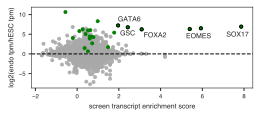

In [20]:
fig = plt.figure(figsize=(4,1.5))

plt.axhline(y=0, linestyle="dashed", color="black", linewidth=1)
plt.scatter(experimental_nonan["effect_size"], experimental_nonan["endo_hESC_log2fc"], s=10,
            color="darkgray", alpha=0.9)
plt.scatter(control["effect_size"], control["endo_hESC_log2fc"], s=10,
            color="green", alpha=1)

# plot controls
plt.scatter(sox17["effect_size"], sox17["endo_hESC_log2fc"], s=10,
         color="green", alpha=1, linewidths=1, edgecolors="black")
plt.annotate(s="SOX17", xy=(sox17["effect_size"], sox17["endo_hESC_log2fc"]),
             xytext=(-15, -10), textcoords="offset points", fontsize=7)

plt.scatter(foxa2["effect_size"], foxa2["endo_hESC_log2fc"], s=10,
         color="green", alpha=1, linewidths=1, edgecolors="black")
plt.annotate(s="FOXA2", xy=(foxa2["effect_size"], foxa2["endo_hESC_log2fc"]),
             xytext=(2, -8), textcoords="offset points", fontsize=7)

plt.scatter(gsc["effect_size"], gsc["endo_hESC_log2fc"], s=10,
         color="green", alpha=1, linewidths=1, edgecolors="black")
plt.annotate(s="GSC", xy=(gsc["effect_size"], gsc["endo_hESC_log2fc"]),
             xytext=(2, -10), textcoords="offset points", fontsize=7)

plt.scatter(gata6["effect_size"], gata6["endo_hESC_log2fc"], s=10,
         color="green", alpha=1, linewidths=1, edgecolors="black")
plt.annotate(s="GATA6", xy=(gata6["effect_size"], gata6["endo_hESC_log2fc"]),
             xytext=(-10, 6), textcoords="offset points", fontsize=7)

plt.scatter(eomes1["effect_size"], eomes1["endo_hESC_log2fc"], s=10,
         color="green", alpha=1, linewidths=1, edgecolors="black")
plt.scatter(eomes2["effect_size"], eomes2["endo_hESC_log2fc"], s=10,
         color="green", alpha=1, linewidths=1, edgecolors="black")
plt.annotate(s="EOMES", xy=(eomes1["effect_size"], eomes1["endo_hESC_log2fc"]),
             xytext=(-15, -10), textcoords="offset points", fontsize=7)

plt.xlabel("screen transcript enrichment score")
plt.ylabel("log2(endo tpm/hESC tpm)")

#plt.xscale('symlog')
 
# #plt.xlim((-0.05, 1.7))
#fig.savefig("FigS5D.pdf", dpi="figure", bbox_inches="tight")

## 5. plot expression, tissue-specificity & expression change for hits vs. non hits

In [21]:
def is_crisphie_hit(row):
    if pd.isnull(row.CRISPhieRmix_FDR):
        return "not considered"
    elif row.CRISPhieRmix_FDR < 0.1:
        return "hit"
    else:
        if row.CRISPhieRmix_FDR > 0.9:
            if row.n_sgRNA >= 9:
                return "stringent no hit"
            else:
                return "no hit"
        else:
            return "no hit"

In [22]:
data_w_seq["is_hit"] = data_w_seq.apply(is_crisphie_hit, axis=1)
data_w_seq.is_hit.value_counts()

no hit              11320
stringent no hit      357
hit                    99
Name: is_hit, dtype: int64

In [23]:
data_w_seq[data_w_seq["is_hit"] == "stringent no hit"].ctrl_status.value_counts()

experimental    336
mRNA             20
control           1
Name: ctrl_status, dtype: int64

In [24]:
data_w_seq[(data_w_seq["is_hit"] == "stringent no hit") & (data_w_seq["ctrl_status"] == "control")]

,group_id,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA,tss_id,gene_name,gene_id,...,endo_rep1,endo_rep2,meso_rep1,meso_rep2,hESC_mean,endo_mean,threshold,qval_hESC_endo,endo_hESC_log2fc,is_hit
11531,NC_000002.12:+:47345173,control,protein_coding,0.972247,0.517896,no hit,9,NC_000002.12:+:47345173,EPCAM,ENSG00000119888.10_1,...,53.330504,77.076675,0.711281,0.506479,40.800392,65.203589,expressed,0.0591925749348997,0.663393,stringent no hit


In [25]:
hits = data_w_seq[data_w_seq["is_hit"] == "hit"]
print(len(hits.group_id.unique()))
hits.head()

78


,group_id,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA,tss_id,gene_name,gene_id,...,endo_rep1,endo_rep2,meso_rep1,meso_rep2,hESC_mean,endo_mean,threshold,qval_hESC_endo,endo_hESC_log2fc,is_hit
0,NC_000008.11:+:54457934,control,protein_coding,0.0,7.864574,hit,7,NC_000008.11:+:54457934,SOX17,ENSG00000164736.5_1,...,140.150442,128.702584,0.000000,0.048871,0.110290,134.426513,expressed,0.000991006472787698,6.930430,hit
1,NC_000003.12:-:27722707,control,protein_coding,0.0,5.932002,hit,6,NC_000003.12:-:27722707,EOMES,ENSG00000163508.12_1,...,95.443310,106.972272,0.015622,0.000000,0.123413,101.207791,expressed,0.0217931946808208,6.507473,hit
2,NC_000003.12:-:27722322,control,protein_coding,0.0,5.397301,hit,6,NC_000003.12:-:27722322,EOMES,ENSG00000163508.12_1,...,85.411152,84.965348,0.025561,0.033138,0.084601,85.188250,expressed,0.000510199113682609,6.312255,hit
3,NC_000023.11:-:11111137,experimental,promoter_overlap,0.0,4.211808,hit,7,NC_000023.11:-:11111137,RP11-120D5.1,ENSG00000234129.7_1,...,0.096875,0.114846,0.234247,0.110035,0.233374,0.105861,expressed,0.131008798190622,-0.157441,hit
4,NC_000023.11:-:11111137,experimental,promoter_overlap,0.0,4.211808,hit,7,NC_000023.11:-:11111137,RP11-120D5.1,ENSG00000234129.7_1,...,0.234414,0.192599,0.084250,0.254724,1.054871,0.213507,expressed,0.06216162574500401,-0.759866,hit


In [26]:
hits[["gene_name", "ctrl_status", "cleaner_transcript_biotype", "effect_size"]].drop_duplicates().sort_values(by="effect_size", ascending=False)

,gene_name,ctrl_status,cleaner_transcript_biotype,effect_size
0,SOX17,control,protein_coding,7.864574
1,EOMES,control,protein_coding,5.932002
2,EOMES,control,protein_coding,5.397301
3,RP11-120D5.1,experimental,promoter_overlap,4.211808
31,PITPNA-AS1,experimental,promoter_overlap,3.306880
...,...,...,...,...
93,MEG3,experimental,transcript_overlap,0.433516
80,MKLN1-AS,experimental,promoter_overlap,0.364211
16,CTD-2545G14.4,experimental,promoter_overlap,0.266646
51,KB-1732A1.1,experimental,intergenic,0.096352


In [27]:
hits[["gene_name", "ctrl_status", "cleaner_transcript_biotype", "effect_size"]].drop_duplicates().cleaner_transcript_biotype.value_counts()

promoter_overlap      35
intergenic            18
protein_coding        13
transcript_overlap    10
gene_nearby            2
Name: cleaner_transcript_biotype, dtype: int64

In [28]:
data_w_seq["endo_hESC_abslog2fc"] = np.abs(data_w_seq["endo_hESC_log2fc"])

## 6. plot expression change v. enrichment score for stringent hits only

In [29]:
data_w_seq["neg_log_FDR"] = -np.log10(data_w_seq["CRISPhieRmix_FDR"]+1e-12)

In [30]:
hits = data_w_seq[data_w_seq["is_hit"] == "hit"]
experimental = hits[hits["ctrl_status"] == "experimental"]
control = hits[hits["ctrl_status"] == "control"]
mrna = hits[hits["ctrl_status"] == "mRNA"]
control["gene_name"]

0     SOX17
1     EOMES
2     EOMES
8     FOXA2
43    GATA6
61      GSC
Name: gene_name, dtype: object

In [31]:
nopromover = experimental[experimental["cleaner_transcript_biotype"] != "promoter_overlap"]
len(nopromover)

34

In [32]:
experimental.sort_values(by="endo_hESC_abslog2fc", ascending=False)[["gene_name", "transcript_name", 
                                                                     "cleaner_transcript_biotype", "hESC_mean",
                                                                      "endo_mean", "endo_hESC_log2fc",
                                                                     "qval_hESC_endo", "CRISPhieRmix_FDR"]].head(10)

,gene_name,transcript_name,cleaner_transcript_biotype,hESC_mean,endo_mean,endo_hESC_log2fc,qval_hESC_endo,CRISPhieRmix_FDR
17,RP11-1144P22.1,RP11-1144P22.1-002,intergenic,209.149826,4.847509,-5.167452,0.00030118251436289303,4.389408e-09
18,RP11-1144P22.1,RP11-1144P22.1-001,intergenic,26.702116,1.335287,-3.568324,0.000847942026383892,4.389408e-09
44,CTD-2058B24.2,CTD-2058B24.2-002,transcript_overlap,2.097034,24.584420,3.046307,0.00103399840876965,8.941190e-05
23,DANCR,DANCR-002,intergenic,145.472379,20.296771,-2.781922,0.00106611529163475,2.446678e-07
94,DIGIT,DIGIT,promoter_overlap,0.012711,4.846082,2.529248,0.008168525422325441,7.633420e-02
46,RP11-222K16.2,RP11-222K16.2-001,intergenic,0.000000,3.394871,2.135821,0.00149981693904295,1.512049e-04
79,FOXD3-AS1,FOXD3-AS1-004,promoter_overlap,2.815925,0.065131,-1.841002,0.0180047193533679,2.187172e-02
25,DANCR,DANCR-004,intergenic,1.553557,0.391437,-0.875932,0.0255173435617054,2.446678e-07
52,RP11-479O16.1,RP11-479O16.1-002,transcript_overlap,0.448650,1.618511,0.854038,0.0251300534434505,7.453342e-04
4,RP11-120D5.1,RP11-120D5.1-005,promoter_overlap,1.054871,0.213507,-0.759866,0.06216162574500401,0.000000e+00


## 7. mark hits in all RNA-seq data

In [33]:
no_na = data_w_seq[~pd.isnull(data_w_seq["qval_hESC_endo"])]
no_na = no_na[~no_na["qval_hESC_endo"].str.contains("NA")]
no_na["qval_log10_hESC_endo"] = -np.log10(no_na["qval_hESC_endo"].astype(float))
len(no_na)

8715

In [34]:
no_na = no_na[~pd.isnull(no_na["CRISPhieRmix_FDR"])]
len(no_na)

8715

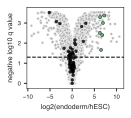

In [35]:
fig = plt.figure(figsize=(1.75, 1.5))

ncRNA = no_na[no_na["ctrl_status"] == "experimental"]
mRNA = no_na[no_na["ctrl_status"] == "control"]
de = no_na[no_na["ctrl_status"] == "mRNA"]

ncRNA_hits = ncRNA[ncRNA["is_hit"] == "hit"]
ctrl_hits = mRNA[mRNA["is_hit"] == "hit"]

ax = sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=no_na, fit_reg=False, 
                 color="darkgray", scatter_kws={"s": 8, "edgecolors": "white", "linewidths": 0.5})
sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=ctrl_hits, fit_reg=False, 
            color=sns.color_palette()[2], scatter_kws={"s": 10, "edgecolors": "black", "linewidths": 0.5}, ax=ax)
sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=ncRNA_hits, fit_reg=False, 
            color="black", scatter_kws={"s": 8, "edgecolors": "black", "linewidths": 0.5}, ax=ax)


plt.xlabel("log2(endoderm/hESC)")
plt.ylabel("negative log10 q value")
# plt.ylim((-0.1, 4))
# plt.xlim((-8.5, 8.5))
plt.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=1)
#plt.title("volcano plot for ncRNAs in endoderm vs. hESCs\n(n=%s)" % (len(diff_hESC_endo_ncRNA)))
#plt.savefig("Fig5J.pdf", bbox_inches="tight", dpi="figure")

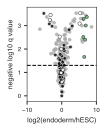

In [36]:
fig = plt.figure(figsize=(1.25, 1.75))

no_hits = no_na[no_na["is_hit"] == "stringent no hit"]

ncRNA_hits = ncRNA[ncRNA["is_hit"] == "hit"]
ctrl_hits = mRNA[mRNA["is_hit"] == "hit"]
de_hits = de[de["is_hit"] == "hit"]

ax = sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=no_hits, fit_reg=False, 
                 color="darkgray", scatter_kws={"s": 10, "edgecolors": "darkgray", "linewidths": 0.5})
sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=ctrl_hits, fit_reg=False, 
            color=sns.color_palette()[2], scatter_kws={"s": 10, "edgecolors": "black", "linewidths": 0.5}, ax=ax)
sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=ncRNA_hits, fit_reg=False, 
            color="black", scatter_kws={"s": 12, "edgecolors": "white", "linewidths": 0.5}, ax=ax)
sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=de_hits, fit_reg=False, 
            color="white", scatter_kws={"s": 12, "edgecolors": "black", "linewidths": 0.5}, ax=ax)


plt.xlabel("log2(endoderm/hESC)")
plt.ylabel("negative log10 q value")
# plt.ylim((-0.1, 4))
plt.xlim((-10, 10))
plt.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=1)
fig.savefig("Fig5G.pdf", bbox_inches="tight", dpi="figure")

In [37]:
# fisher's exact (all biotypes)
tmp = no_na[no_na["is_hit"].isin(["stringent no hit", "hit"])]
tmp_node = tmp[tmp["qval_log10_hESC_endo"] <= -np.log10(0.05)]
tmp_de = tmp[tmp["qval_log10_hESC_endo"] > -np.log10(0.05)]

de_hit = len(tmp_de[tmp_de["is_hit"] == "hit"])
de_nohit = len(tmp_de[tmp_de["is_hit"] == "stringent no hit"])
node_hit = len(tmp_node[tmp_node["is_hit"] == "hit"])
node_nohit = len(tmp_node[tmp_node["is_hit"] == "stringent no hit"])

stats.fisher_exact([[de_hit, de_nohit], [node_hit, node_nohit]])

(1.1963302752293579, 0.5209547570006476)

In [38]:
# proportion of lncRNA hits w/in classes
tmp_node_lnc = tmp_node[tmp_node["ctrl_status"] == "experimental"]
tmp_de_lnc = tmp_de[tmp_de["ctrl_status"] == "experimental"]

node_lnc_hit = len(tmp_node_lnc[tmp_node_lnc["is_hit"] == "hit"])
node_lnc_nohit = len(tmp_node_lnc[tmp_node_lnc["is_hit"] == "stringent no hit"])
de_lnc_hit = len(tmp_de_lnc[tmp_de_lnc["is_hit"] == "hit"])
de_lnc_nohit = len(tmp_de_lnc[tmp_de_lnc["is_hit"] == "stringent no hit"])

p_hit_lnc_de = de_lnc_hit/(de_lnc_hit+de_lnc_nohit)
p_hit_lnc_node = node_lnc_hit/(node_lnc_hit+node_lnc_nohit)

print("%% of hits within differentially expressed lncRNAs: %s" % p_hit_lnc_de)
print("%% of hits within non-differentially expressed lncRNAs: %s" % p_hit_lnc_node)

% of hits within differentially expressed lncRNAs: 0.20689655172413793
% of hits within non-differentially expressed lncRNAs: 0.19900497512437812


## 6. write file

In [39]:
f = "../../../data/02__screen/02__enrichment_data/enrichment_values.with_rna_seq.UPDATED.txt"

In [40]:
data_w_seq.columns

Index(['group_id', 'ctrl_status', 'transcript_biotype_status',
       'CRISPhieRmix_FDR', 'effect_size', 'hit_status', 'n_sgRNA', 'tss_id',
       'gene_name', 'gene_id', 'transcript_name', 'transcript_id', 'csf',
       'cleaner_gene_biotype', 'cleaner_transcript_biotype', 'hESC_rep1',
       'hESC_rep2', 'endo_rep1', 'endo_rep2', 'meso_rep1', 'meso_rep2',
       'hESC_mean', 'endo_mean', 'threshold', 'qval_hESC_endo',
       'endo_hESC_log2fc', 'is_hit', 'endo_hESC_abslog2fc', 'neg_log_FDR'],
      dtype='object')

In [41]:
data_w_seq = data_w_seq[["group_id", "ctrl_status", "gene_name", "gene_id", "transcript_name",
                         "transcript_id", "cleaner_transcript_biotype", "cleaner_gene_biotype", "CRISPhieRmix_FDR", 
                         "is_hit", "effect_size",
                         "csf", "hESC_mean", "endo_mean", "qval_hESC_endo", "endo_hESC_log2fc",
                         "endo_hESC_abslog2fc"]]
data_w_seq.head()

,group_id,ctrl_status,gene_name,gene_id,transcript_name,transcript_id,cleaner_transcript_biotype,cleaner_gene_biotype,CRISPhieRmix_FDR,is_hit,effect_size,csf,hESC_mean,endo_mean,qval_hESC_endo,endo_hESC_log2fc,endo_hESC_abslog2fc
0,NC_000008.11:+:54457934,control,SOX17,ENSG00000164736.5_1,SOX17-001,ENST00000297316.4_1,protein_coding,protein_coding,0.0,hit,7.864574,protein_coding,0.110290,134.426513,0.000991006472787698,6.930430,6.930430
1,NC_000003.12:-:27722707,control,EOMES,ENSG00000163508.12_1,EOMES-004,ENST00000461503.2_1,protein_coding,protein_coding,0.0,hit,5.932002,protein_coding,0.123413,101.207791,0.0217931946808208,6.507473,6.507473
2,NC_000003.12:-:27722322,control,EOMES,ENSG00000163508.12_1,EOMES-001,ENST00000295743.8_1,protein_coding,protein_coding,0.0,hit,5.397301,protein_coding,0.084601,85.188250,0.000510199113682609,6.312255,6.312255
3,NC_000023.11:-:11111137,experimental,RP11-120D5.1,ENSG00000234129.7_1,RP11-120D5.1-004,ENST00000608176.5_1,promoter_overlap,promoter_overlap,0.0,hit,4.211808,lncRNA_good_csf,0.233374,0.105861,0.131008798190622,-0.157441,0.157441
4,NC_000023.11:-:11111137,experimental,RP11-120D5.1,ENSG00000234129.7_1,RP11-120D5.1-005,ENST00000608916.1_1,promoter_overlap,promoter_overlap,0.0,hit,4.211808,lncRNA_good_csf,1.054871,0.213507,0.06216162574500401,-0.759866,0.759866


In [42]:
data_w_seq = data_w_seq.sort_values(by="effect_size", ascending=False)
data_w_seq.to_csv(f, sep="\t", index=False)

## 7. investigate expression of the 6 hits in cluster 1
FOXD3-AS1, LAMTOR5-AS1, VLDLR-AS1, HOXC-AS1, MEG3, LINC00623

In [43]:
data_w_seq.columns

Index(['group_id', 'ctrl_status', 'gene_name', 'gene_id', 'transcript_name',
       'transcript_id', 'cleaner_transcript_biotype', 'cleaner_gene_biotype',
       'CRISPhieRmix_FDR', 'is_hit', 'effect_size', 'csf', 'hESC_mean',
       'endo_mean', 'qval_hESC_endo', 'endo_hESC_log2fc',
       'endo_hESC_abslog2fc'],
      dtype='object')

In [44]:
tmp = data_w_seq[data_w_seq["gene_name"].isin(["FOXD3-AS1", "LAMTOR5-AS1", "VLDLR-AS1", "HOXC-AS1", "MEG3",
                                                "LINC00623"])]
tmp = tmp[tmp["is_hit"] == "hit"]
tmp.sort_values(by=["endo_hESC_abslog2fc", "gene_name"], ascending=False)

,group_id,ctrl_status,gene_name,gene_id,transcript_name,transcript_id,cleaner_transcript_biotype,cleaner_gene_biotype,CRISPhieRmix_FDR,is_hit,effect_size,csf,hESC_mean,endo_mean,qval_hESC_endo,endo_hESC_log2fc,endo_hESC_abslog2fc
79,NC_000001.11:-:63323741,experimental,FOXD3-AS1,ENSG00000230798.5_1,FOXD3-AS1-004,ENST00000431294.5_1,promoter_overlap,transcript_overlap,2.187172e-02,hit,0.910762,lncRNA_good_csf,2.815925,0.065131,0.0180047193533679,-1.841002,1.841002
66,NC_000009.12:-:2522018,experimental,VLDLR-AS1,ENSG00000236404.8_1,VLDLR-AS1-004,ENST00000447278.1_1,intergenic,transcript_overlap,1.112902e-02,hit,0.466612,lncRNA_good_csf,3.715940,1.862828,0.0420305530901966,-0.720104,0.720104
93,NC_000014.9:+:100833536,experimental,MEG3,ENSG00000214548.14_2,MEG3-018,ENST00000524035.5_1,transcript_overlap,transcript_overlap,7.151317e-02,hit,0.433516,lncRNA_good_csf,0.005524,0.232434,0.0368878334443003,0.293563,0.293563
70,NC_000001.11:+:110407783,experimental,LAMTOR5-AS1,ENSG00000224699.8_1,LAMTOR5-AS1-022,ENST00000609709.5_1,promoter_overlap,transcript_overlap,1.330185e-02,hit,2.288414,lncRNA_good_csf,0.170290,0.371025,0.38988373961177797,0.228390,0.228390
67,NC_000001.11:+:110407783,experimental,LAMTOR5-AS1,ENSG00000224699.8_1,LAMTOR5-AS1-006,ENST00000587691.1_1,promoter_overlap,transcript_overlap,1.330185e-02,hit,2.288414,lncRNA_good_csf,0.158044,0.333011,sleuth NA,0.202999,0.202999
71,NC_000001.11:+:110407783,experimental,LAMTOR5-AS1,ENSG00000224699.8_1,LAMTOR5-AS1-023,ENST00000610148.5_1,promoter_overlap,transcript_overlap,1.330185e-02,hit,2.288414,lncRNA_good_csf,0.135182,0.039498,sleuth NA,-0.127036,0.127036
69,NC_000001.11:+:110407783,experimental,LAMTOR5-AS1,ENSG00000224699.8_1,LAMTOR5-AS1-014,ENST00000608253.1_1,promoter_overlap,transcript_overlap,1.330185e-02,hit,2.288414,lncRNA_good_csf,0.533238,0.446500,0.17612973504964502,-0.084016,0.084016
72,NC_000001.11:+:110407783,experimental,LAMTOR5-AS1,ENSG00000224699.8_1,LAMTOR5-AS1-031,ENST00000612551.4_1,promoter_overlap,transcript_overlap,1.330185e-02,hit,2.288414,lncRNA_good_csf,0.697163,0.759826,0.238541776391718,0.052307,0.052307
57,NC_000001.11:+:120952589,experimental,LINC00623,ENSG00000235398.4,LINC00623-013,ENST00000457645.1,intergenic,transcript_overlap,1.748338e-03,hit,1.297519,lncRNA_good_csf,0.227406,0.220316,1.0,-0.008359,0.008359
68,NC_000001.11:+:110407783,experimental,LAMTOR5-AS1,ENSG00000224699.8_1,LAMTOR5-AS1-020,ENST00000608067.5_1,promoter_overlap,transcript_overlap,1.330185e-02,hit,2.288414,lncRNA_good_csf,0.000000,0.000000,sleuth NA,0.000000,0.000000


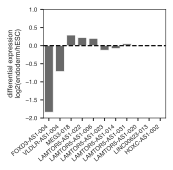

In [45]:
order = ["FOXD3-AS1-004", "VLDLR-AS1-004", "MEG3-018", "LAMTOR5-AS1-022", "LAMTOR5-AS1-006", "LAMTOR5-AS1-023",
         "LAMTOR5-AS1-014", "LAMTOR5-AS1-031", "LAMTOR5-AS1-020", "LINC00623-013", "HOXC-AS1-002"]

fig = plt.figure(figsize=(2.2, 2))
ax = sns.barplot(data=tmp, x="transcript_name", y="endo_hESC_log2fc", order=order, color="dimgray")
ax.set_xlabel("")
ax.set_xticklabels(order, rotation=40, ha="right", va="top")
ax.set_ylabel("differential expression\nlog2(endoderm/hESC)")
ax.axhline(y=0, color="black", linestyle="dashed")
ax.set_ylim((-2, 1))

fig.savefig("Fig7A.pdf", dpi="figure", bbox_inches="tight")